# Proyecto modelamiento pt2
Irma Pizarro, Ángel Paisano

## Descripción y comentarios del proyecto
En este proyecto se usan herramientas computacionales para modelar los espectros de un cubo IFU (integral field unit) donde cada pixel tiene un espectro, para extraer propiedades físicas de la galaxia **NGC4990**. En concreto se hace un análisis de la cinemática y población estelar junto con un análiss del gas de esta galaxia.


Para llevar a cabo el análisis usamos el paquete **ppxf** Penalized Pixel-Fitting, un paquete desarrollado por Michele Cappellari que nos permite ajustar los espectros y obtener parámetros fundamentales como la velocidad estelar, la dispersión de velocidades, la edad y metalicidad de la población estelar.

**NGC 4990**
Se trata de una galaxia lenticular ubicada en la constelición de Virgo, cuyas características se someten al análisis mencionado anteriormente.

In [ ]:
!pip install ppxf #instalamos ppxf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.0 MB/s eta 0:00:00


In [ ]:
import numpy as np #importamos algunas librerias importantes
from ppxf.ppxf import ppxf
from astropy.io import fits
import ppxf.ppxf_util as util

In [ ]:
hdu= fits.open('NGC4990_small.fits') #abrimos la data de la galaxia y vemos su info
print(hdu.info())
data= hdu[0].data[:3600,:,:]     #hacemos un pequeño recorte ppara que el ejuste coincida
print(hdu[0].header)     #vemos el header para desempaquetar valores


Filename: NGC4990_small.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  CUBE          1 PrimaryHDU      53   (10, 10, 3682)   float32   
  1  VARIANCE      1 ImageHDU        54   (10, 10, 3682)   float32   
None
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                   10                                                  NAXIS2  =                   10                                                  NAXIS3  =                 3682                                                  EXTEND  =                    T                                                  EXTNAME = 'CUBE    '           / This extension contains data values            HDUCLASS= 'ESO     '           / class name (ESO format)                        HDUDOC  = 'DICD    '           / document wi

In [ ]:
header_hdu1= hdu[1].header
noise=  np.sqrt(hdu[1].data[:3600,:,:])
noise.shape #aprovechamos de verificar las dimensiones para corroborar el recorte

(3600, 10, 10)

## Extracción de los datos
El redshift se obtuvo de NED database
redshift= 0.010574 ± 2.30e-5

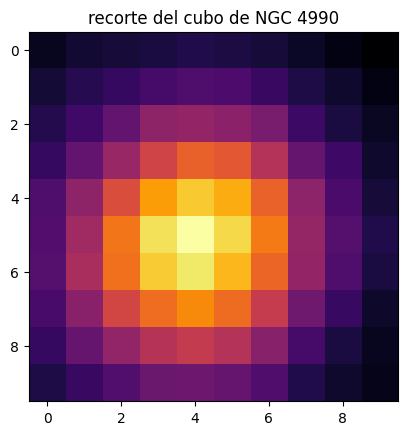

In [ ]:
import matplotlib.pyplot as plt    #visualizamos un slice del cubo
plt.imshow(data[15,:,:],cmap='inferno')
plt.title('recorte del cubo de NGC 4990')
plt.show()

### Extracción de la longitud de onda

In [ ]:
crval= hdu[0].header['CRVAL3']
cdelt= hdu[0].header['CDELT3']
crpix= hdu[0].header['CRPIX3']
naxis= hdu[0].header['NAXIS3'] =3600 #cambiar para recortar

In [ ]:
#error = np.sqrt( hdu[1].data)/median_gal
# ahora establecemos las longitudes y corregimos por el redshift
redshift= 0.010574
lamRange = crval+ np.array([0., cdelt *(naxis - 1)])
lamRange_c= lamRange/(1+redshift)
fwhm= 2.55
fwhm= fwhm/(1+ redshift)
ruido= noise[:,1,1]/(1+ redshift)      #tomamos el ruido de 1 espectro

Obtenemos velscale ln_lam1 y el flujo: galaxy en el formato correcto para nuestro ajuste de ppxf

In [ ]:
galaxy, ln_lam1, velscale = util.log_rebin(lamRange_c , data[:,1,1])  #tomamos 1 espectro
lam_gal= np.exp(ln_lam1)
print(lam_gal)

[4699.78034269 4700.65063676 4701.52109199 ... 9148.02452276 9149.71853204
 9151.41285501]


In [ ]:
#ahora normalizamos el ruido y el flujo
#pero para normalizar eliminamos los valores nan de galaxy y del ruido porque
#con esto no nos permite calcular la mediana

galaxy[~np.isfinite(galaxy)] = 0
ruido_clean = np.nan_to_num(ruido, nan=1e-3)
ruido_norm = ruido / np.median(galaxy)
galaxy_norm= galaxy/np.median(galaxy)


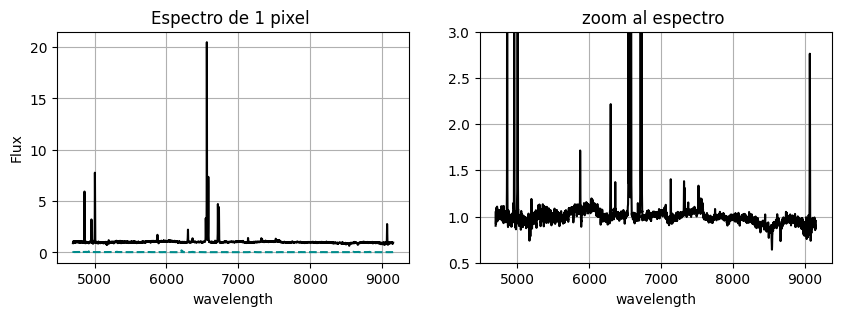

In [ ]:
# grafico de un espectro
fig, ax= plt.subplots(1,2,figsize=(10,3))
ax[0].plot(lam_gal,galaxy_norm,c='black')
ax[0].plot(lam_gal,ruido_norm,c='darkcyan',ls='--')
ax[0].set_title('Espectro de 1 pixel ')
ax[0].set_xlabel('wavelength')
ax[0].set_ylabel('Flux')
ax[0].grid('on')

ax[1].plot(lam_gal,galaxy_norm,c='black')
ax[1].set_ylim(0.5,3)
ax[1].set_title('zoom al espectro ')
ax[1].set_xlabel('wavelength')
ax[1].grid('on')
plt.show()

El template correspondiente para esta galaxia es emiles considerando que tenemos una fwhm de 2.55 emiles es el template que tiene resolución similar a la que tenemos para la galaxia y además los templates de emiles consideran el rango de longitud de onda en el que estamos trabajando.

In [ ]:
from pathlib import Path
from urllib import request
import ppxf.sps_util as lib

# sps_name = 'fsps'
# sps_name = 'galaxev'
sps_name = 'emiles'
# sps_name = 'xsl'

ppxf_dir = Path(util.__file__).parent
print(ppxf_dir)
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

/usr/local/lib/python3.11/dist-packages/ppxf


Recortamos el template considerando que tenga un rango un poco más grande que el de la galaxia

In [ ]:
#para recortar el template vemos el rango del lam_gal
print(lam_gal[0],lam_gal[-1])

4699.780342685971 9151.412855014023


In [ ]:
lam_range_temp = [3000, 12000]

sps = lib.sps_lib(filename, velscale, fwhm)
print(sps.templates.shape)

(18327, 25, 6)


In [ ]:
ruido_clean = np.nan_to_num(ruido_norm, nan=1e-3)

### Ajuste
Como estamos trabajando con la cinematica usamos mdegree=-1 y degree alto que es lo que permite conseguir un ajuste adecuado.

 Best Fit:       Vel     sigma
 comp.  0:       -66        91
chi2/DOF: 9.602; DOF: 3384; degree = 10; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150


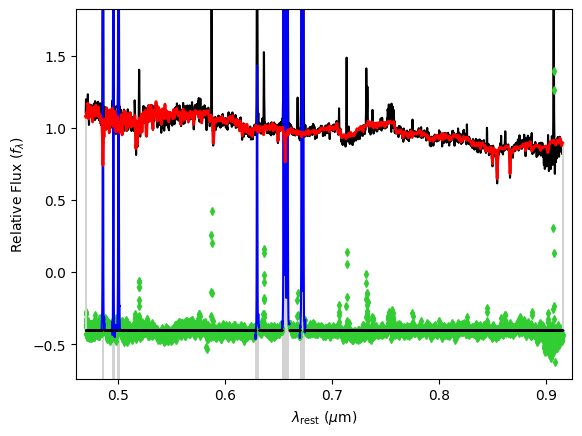

In [ ]:
from time import perf_counter as clock
lam_range_temp = [np.min(sps.lam_temp), np.max(sps.lam_temp)]
goodPixels = util.determine_goodpixels(ln_lam1, lam_range_temp)


c = 299792.458
start = [0, 200.]             # (km/s), starting guess for [V, sigma]


t = clock()
pp = ppxf(sps.templates, galaxy_norm, ruido_clean, velscale, start,
           goodpixels=goodPixels,
          moments=2, lam=np.exp(ln_lam1),lam_temp=sps.lam_temp,
          degree=10, mdegree=-1,plot=True)

### resultados
Tenemos los resultados preeliminares de la velocidad y dispersion de las estrellas y un un chi^2/DOF decente

In [ ]:
print(f'la velocidad radial es: {pp.sol[0]:.2f}') #velocidad (shift lineas de absorción)
print(f'la velocidad de dispersión es: {pp.sol[1]:.2f}') #velocidad de dispersión
print(f'Chi cuadrado: {pp.chi2:.4f}')


la velocidad radial es: -66.14
la velocidad de dispersión es: 90.51
Chi cuadrado: 9.6018


### edad y metalicidad

In [ ]:
# reg_dim es las dimenciones de los templates estelares: en ages y metalicidades.
# sps.templates tiene dimentionces [Template, Age, Metalicidad]
reg_dim = sps.templates.shape[1:]
weights = pp.weights

# Debemos reshape la matriz de weight a la forma de los templates estelares, y luego normalizar
weights = weights.reshape(reg_dim)
sps.mean_age_metal(weights)


Weighted <lg_age> [yr]: 9.56
Weighted <[M/H]>: -0.134


(np.float64(9.562962247385547), np.float64(-0.1336583303661338))

## Mapas de velocidades, edades y metalicidad

Para construir los mapas utilizamos la misma estructura que usamos arriba para un espectro pero ahora para todos los pixeles, de modo que hacemos un doble ciclo que itera por los indices hasta recorrer los 100 pixeles de la imagen y luego guardamos los valores en arrays para las velocidades y en listas para la metalicidad y las edades.

In [ ]:
#queremos replicar lo que hicimos arriba pero en en ciclo de manera que podamos hacerlo por cada pixel
# Crear listas para guardar espectros observados y modelos ajustados
galaxy_list = []
bestfit_list = []
coords = []

nx, ny = data.shape[1:] #creamos los indices a recorrer

# Inicializamos mapas de velocidad y dispersión
vel_map = np.full((nx, ny), 0)
sigma_map = np.full((nx, ny), 0)
age_map= []
metalicity_map= []
for i in range(nx):
  for j in range(ny):
    ruido= noise[:,i,j]/(1+ redshift)      #tomamos el ruido de 1 espectro
    galaxy, ln_lam1, velscale = util.log_rebin(lamRange_c , data[:,i,j])  #tomamos 1 espectro
    lam_gal= np.exp(ln_lam1)


    galaxy[~np.isfinite(galaxy)] = 0
    ruido_clean = np.nan_to_num(ruido, nan=1e-3)
    ruido_norm = ruido / np.median(galaxy)
    galaxy_norm= galaxy/np.median(galaxy)
    ruido_clean = np.nan_to_num(ruido_norm, nan=1e-3)

    sps = lib.sps_lib(filename, velscale, fwhm)
    print(sps.templates.shape)


    lam_range_temp = [np.min(sps.lam_temp), np.max(sps.lam_temp)]
    goodPixels = util.determine_goodpixels(ln_lam1, lam_range_temp)

    c = 299792.458
    start = [0, 200.]             # (km/s), starting guess for [V, sigma]


    t = clock()
    pp = ppxf(sps.templates, galaxy_norm, ruido_clean, velscale, start,
              goodpixels=goodPixels,
              moments=2, lam=np.exp(ln_lam1),lam_temp=sps.lam_temp,
              degree=10, mdegree=-1,plot=False)

    vel_map[i, j] = pp.sol[0]
    sigma_map[i, j] = pp.sol[1]

    # Guardamos el espectro observado y el modelo ajustado
    galaxy_list.append(galaxy_norm)
    bestfit_list.append(pp.bestfit)
    coords.append((i, j))

    reg_dim = sps.templates.shape[1:]
    weights = pp.weights

    # Debemos reshape la matriz de weight a la forma de los templates estelares, y luego normalizar
    weights = weights.reshape(reg_dim)


    age_map.append(sps.mean_age_metal(weights)[0])
    metalicity_map.append(sps.mean_age_metal(weights)[1])

(18327, 25, 6)
 Best Fit:       Vel     sigma
 comp.  0:       -72       113
chi2/DOF: 7.608; DOF: 3384; degree = 10; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
Weighted <lg_age> [yr]: 9.20
Weighted <[M/H]>: 0.00797
Weighted <lg_age> [yr]: 9.20
Weighted <[M/H]>: 0.00797
(18327, 25, 6)
 Best Fit:       Vel     sigma
 comp.  0:       -71        98
chi2/DOF: 6.214; DOF: 3384; degree = 10; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
Weighted <lg_age> [yr]: 9.76
Weighted <[M/H]>: -0.190
Weighted <lg_age> [yr]: 9.76
Weighted <[M/H]>: -0.190
(18327, 25, 6)
 Best Fit:       Vel     sigma
 comp.  0:       -66        92
chi2/DOF: 6.452; DOF: 3384; degree = 10; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
Weighted <lg_age> [yr]: 9.82
Weighted <[M/H]>: 

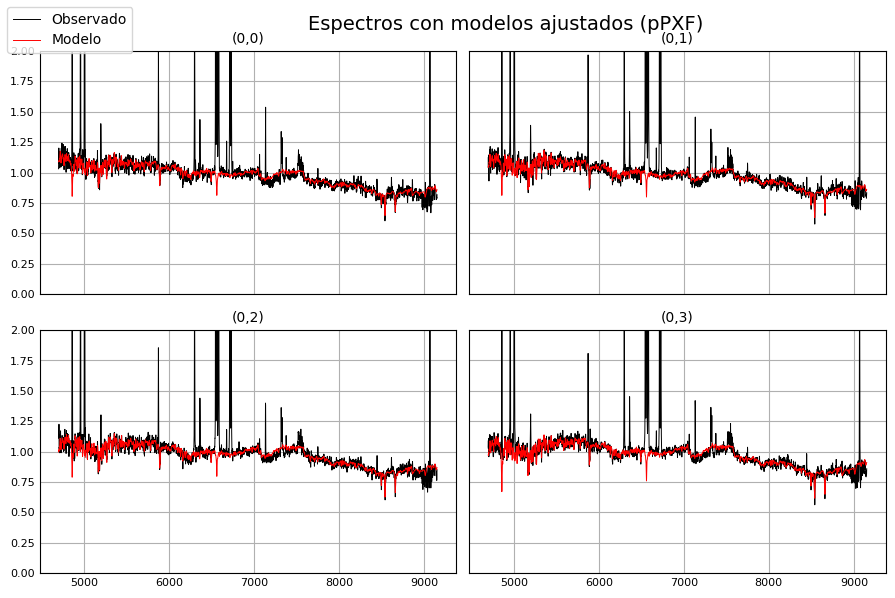

In [ ]:
# --- Graficar algunos espectros y sus ajustes ---
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)

for idx, ax in enumerate(axs.flat):
    if idx < 4:  # sólo mostramos los primeros 4
        ax.plot(lam_gal, galaxy_list[idx], lw=0.7, color='black', label='Observado')
        ax.plot(lam_gal, bestfit_list[idx], lw=0.7, color='red', label='Modelo')
        i, j = coords[idx]
        ax.set_title(f"({i},{j})", fontsize=10)
        ax.tick_params(axis='both', which='both', length=0, labelsize=8)
        ax.grid('on')
    else:
        ax.axis('off')

# Agregamos una única leyenda general
fig.legend(['Observado', 'Modelo'], loc='upper left', fontsize=10)
fig.suptitle("Espectros con modelos ajustados (pPXF)", fontsize=14)
plt.tight_layout()
plt.ylim(0,2)
plt.subplots_adjust(top=0.92, right=0.88)
plt.show()

### Mapa de edades y metalicidad

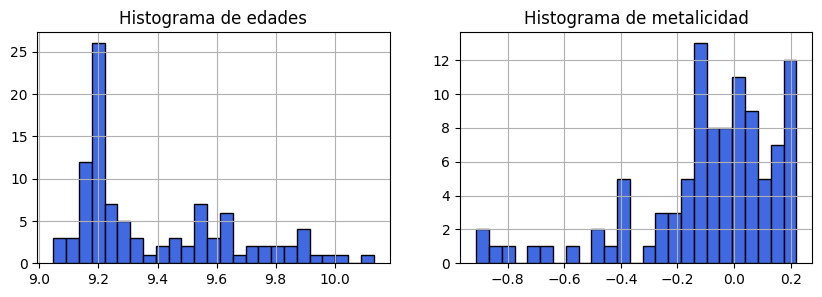

In [ ]:
age = np.array(age_map)
metal= np.array(metalicity_map)

age_flat= age.flatten()
metal_flat= metal.flatten()

fig, ax= plt.subplots(1,2,figsize=(10,3))
ax[0].hist(age, bins=25, color='royalblue', edgecolor='black')
ax[0].set_title('Histograma de edades')
ax[0].grid('on')
ax[1].hist(metal, bins=25, color='royalblue', edgecolor='black')
ax[1].set_title('Histograma de metalicidad')
ax[1].grid('on')
plt.show()

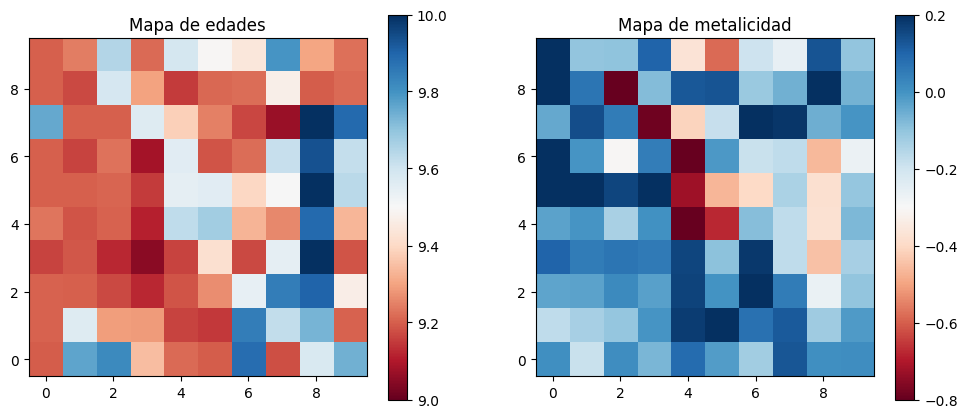

In [ ]:
#ahora graficamos la edad y metalicidad

age_matrix = age.reshape(10, 10)
metal_matrix = metal.reshape(10, 10)


fig, ax = plt.subplots(1, 2, figsize=(12, 5))
im1 = ax[0].imshow(age_matrix, origin='lower', cmap='RdBu', vmin=9, vmax=10)
ax[0].set_title("Mapa de edades")
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].imshow(metal_matrix, origin='lower', cmap='RdBu', vmin=-0.8, vmax=0.2)
ax[1].set_title("Mapa de metalicidad")
fig.colorbar(im2, ax=ax[1])
plt.show()

### Mapas de velocidad y dispersión para la componente estelar

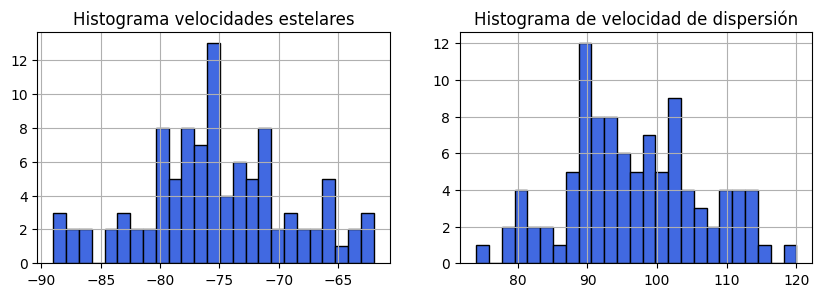

In [ ]:
# Aplanar los mapas para hacer los histogramas
vel_flat = vel_map.flatten()
# Eliminamos valores no válidos o extremos NaNs o inf
vel_clean = vel_flat[np.isfinite(vel_flat)]

# aplicamos lo mismo en el histograma de la dispersión
sigma_flat = sigma_map.flatten()
sigma_clean = sigma_flat[np.isfinite(sigma_flat)]



fig, ax= plt.subplots(1,2,figsize=(10,3))
ax[0].hist(vel_clean, bins=25, color='royalblue', edgecolor='black')
ax[0].set_title('Histograma velocidades estelares')
ax[0].grid('on')
ax[1].hist(sigma_clean, bins=25, color='royalblue', edgecolor='black')
ax[1].set_title('Histograma de velocidad de dispersión')
ax[1].grid('on')
plt.show()

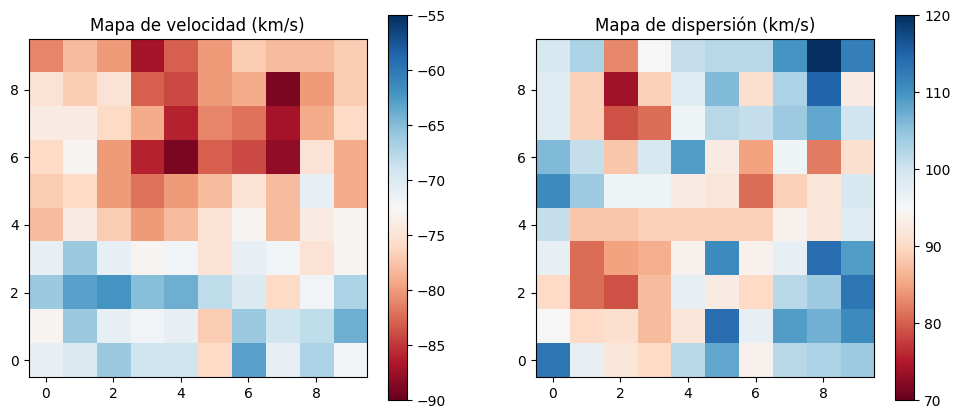

In [ ]:
#ahora graficamos los mapas de velocidad
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
im1 = ax[0].imshow(vel_map, origin='lower', cmap='RdBu', vmin=-90, vmax=-55)
ax[0].set_title("Mapa de velocidad (km/s)")
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].imshow(sigma_map, origin='lower', cmap='RdBu', vmin=70, vmax=120)
ax[1].set_title("Mapa de dispersión (km/s)")
fig.colorbar(im2, ax=ax[1])
plt.show()

### ¿Qué nos dice el mapa de velocidades?
Al observar el mapa de velocidades podemos ver que al centro está la velocidad mayor en módulo, (más negativa) y la mayor parte de las velocidades con valores mayores se concentran en la parte superior y un poco a la izquierda, de modo que podemos deducir:


*   La galaxia se esta acercando a nosotros en su totalidad porque toda la velocidad es negativa
*   Las partes con mayor magnitud nos indican que la galaxia está rotando hacia nosotros o bien la parte de arriba se acerca más rápido



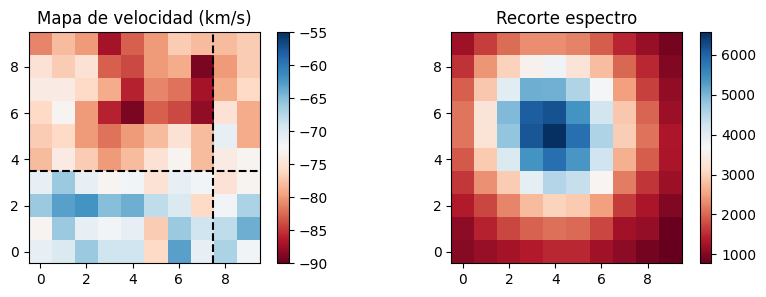

In [ ]:
#ahora graficamos los mapas de velocidad
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
im1 = ax[0].imshow(vel_map, origin='lower', cmap='RdBu', vmin=-90, vmax=-55)
ax[0].set_title("Mapa de velocidad (km/s)")
ax[0].axvline(x=7.5, color='black', linestyle='--')
ax[0].axhline(y=3.5, color='black', linestyle='--')
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].imshow(data[1,:,:], origin='lower', cmap='RdBu')
ax[1].set_title("Recorte espectro")
fig.colorbar(im2, ax=ax[1])
plt.show()


## Líneas de emisión y parametros del gas
Para el análisis del gas usamos la misma estructura vista en clases para ajustes las líneas de emisión y de esa forma estudiar la cinemática del gas, añadiendo esta vez una gas component al ajuste y usando regul=300

In [ ]:
# dimensiones de los parametros estelares: metalicidad y edad
reg_dim = sps.templates.shape[1:]
stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)


In [ ]:
tie_balmer =True
lam_range_gal = [np.min(lam_gal), np.max(lam_gal)]
gas_templates, gas_names, line_wave = util.emission_lines(sps.ln_lam_temp, lam_range_gal, fwhm, tie_balmer=1)

templates = np.column_stack([stars_templates, gas_templates])

Emission lines included in gas templates:
['Balmer' '[SII]6716' '[SII]6731' 'HeI5876' '[OIII]5007_d' '[OI]6300_d'
 '[NII]6583_d']


In [ ]:
# Necesitamos la cantidad e templates estelares y del gas, a cada uno le asignamos un valor, 0: estelar, 1 : gas
nTemps = stars_templates.shape[1]
nLines = gas_templates.shape[1]

# Components
component = [0]*nTemps + [1]*nLines

# Moments fit (V,sig) the stars and (V,sig) for the gas
moments = [2, 2]


# guess values
start1 = [-70, 90]
start2 = [-50, 50]
start = [start1, start2] # Para las estrellas, y para el gas

gas_component = np.array(component) > 0


Outliers: 261
Outliers: 20
Outliers: 1
Outliers: 255
Outliers: 17
Outliers: 2
Outliers: 260
Outliers: 14
Outliers: 1
Outliers: 260
Outliers: 14
Outliers: 1
Outliers: 260
Outliers: 14
Outliers: 1
 Best Fit:       Vel     sigma
 comp.  0:       -65       101
 comp.  1:       -60        49
chi2/DOF: 1.120; DOF: 3321; degree = 10; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 114; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 7/157
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                Balmer      91.15     0.067     -60    49
Comp:  1             [SII]6716      11.99     0.046     -60    49
Comp:  1             [SII]6731      10.40     0.053     -60    49
Comp:  1               HeI5876      2.282     0.064     -60    49
Comp:  1          [OIII]5007_d      37.04     0.092     -60    49
Comp:  1       

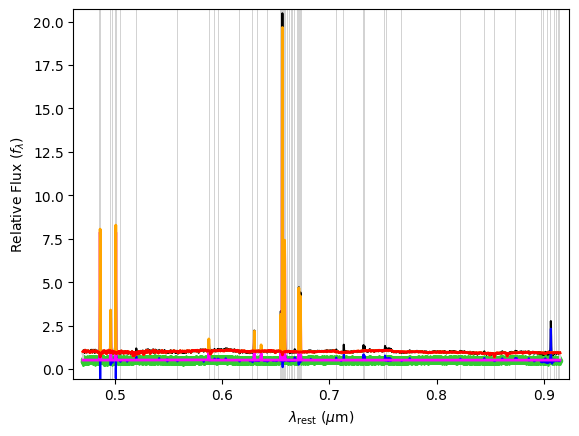

In [ ]:
#regul=0
regul = 300
clean=True
pp_reg = ppxf(lam=lam_gal, lam_temp=sps.lam_temp, templates=templates, galaxy=galaxy_norm, noise=ruido_clean, velscale=velscale,
              start=start, moments=moments, gas_names=gas_names, gas_component=gas_component,component=component, regul=regul,reg_dim=reg_dim,
              degree=10,mdegree=-1, clean=clean,
              plot=True)

En el ajuste de arriba podemos ver que en la galaxia hay al menos 7 líneas de emisión presentes en el gas:


*   Línea de Balmer: que nos habla de la emisión del hidrógeno usualmente Hα

*   2 Líneas de Azufre ionizado SII

*   La línea de Helio HeI

*   La línea de oxigeno ionizado OIII
*   La línea de oxígeno neutro OI


*   Línea de Nitrogeno ionizado NII
Además nos da una buena partida para el posterior ajuste ya que el chi^2/DOF nos da cerca a uno como buscamos.



In [ ]:
#Ahora calculamos el mapa de velocidades y dispersión del gas junnto con el mapa de metalicidad y edades
#vamos a hacerlo sin hacer un mask explicito de las líneas de emisión

nx, ny = data.shape[1:] #creamos los indices a recorrer

# Inicializamos mapas de velocidad y dispersión
vel_map_gas = np.full((nx, ny), 0)
sigma_map_gas = np.full((nx, ny), 0)
metalicity_map= np.full((nx, ny), 0)
age_map= np.full((nx, ny), 0)

for i in range(nx):
  for j in range(ny):
    ruido= noise[:,i,j]/(1+ redshift)      #tomamos el ruido de 1 espectro
    galaxy, ln_lam1, velscale = util.log_rebin(lamRange_c , data[:,i,j])  #tomamos 1 espectro
    lam_gal= np.exp(ln_lam1)


    galaxy[~np.isfinite(galaxy)] = 0
    ruido_clean = np.nan_to_num(ruido, nan=1e-3)
    ruido_norm = ruido / np.median(galaxy)
    galaxy_norm= galaxy/np.median(galaxy)
    ruido_clean = np.nan_to_num(ruido_norm, nan=1e-3)

    sps = lib.sps_lib(filename, velscale, fwhm)


    lam_range_temp = [np.min(sps.lam_temp), np.max(sps.lam_temp)]


    c = 299792.458
        # dimensiones de los parametros estelares: metalicidad y edad
    reg_dim = sps.templates.shape[1:]
    stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)
    tie_balmer =True
    lam_range_gal = [np.min(lam_gal), np.max(lam_gal)]
    gas_templates, gas_names, line_wave = util.emission_lines(sps.ln_lam_temp, lam_range_gal, fwhm, tie_balmer=1)

    templates = np.column_stack([stars_templates, gas_templates])

        # Necesitamos la cantidad e templates estelares y del gas, a cada uno le asignamos un valor, 0: estelar, 1 : gas
    nTemps = stars_templates.shape[1]
    nLines = gas_templates.shape[1]

    # Components
    component = [0]*nTemps + [1]*nLines

    # Moments fit (V,sig) the stars and (V,sig) for the gas
    moments = [2, 2]


    # guess values
    start1 = [-70, 90]
    start2 = [-50, 50]
    start = [start1, start2] # Para las estrellas, y para el gas

    gas_component = np.array(component) > 0
    #regul=0
    regul = 300
    clean=True
    pp_reg = ppxf(lam=lam_gal, lam_temp=sps.lam_temp, templates=templates, galaxy=galaxy_norm, noise=ruido_clean, velscale=velscale,
                  start=start, moments=moments, gas_names=gas_names, gas_component=gas_component,component=component, regul=regul,reg_dim=reg_dim,
                  degree=10,mdegree=-1, clean=clean,
                  plot=False)

    vel_map_gas[i, j] = pp_reg.sol[1][0]
    sigma_map_gas[i, j] = pp_reg.sol[1][1]


Emission lines included in gas templates:
['Balmer' '[SII]6716' '[SII]6731' 'HeI5876' '[OIII]5007_d' '[OI]6300_d'
 '[NII]6583_d']
Outliers: 345
Outliers: 15
Outliers: 2
Outliers: 1
Outliers: 321
Outliers: 16
Outliers: 1
Outliers: 305
Outliers: 16
Outliers: 2
Outliers: 298
Outliers: 16
Outliers: 3
Outliers: 297
Outliers: 17
Outliers: 3
 Best Fit:       Vel     sigma
 comp.  0:       -55       102
 comp.  1:       -48        47
chi2/DOF: 0.9472; DOF: 3279; degree = 10; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 76; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 7/157
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                Balmer      94.94     0.057     -48    47
Comp:  1             [SII]6716      645.0     0.041     -48    47
Comp:  1             [SII]6731      15.51     0.047     -48    47
Comp:

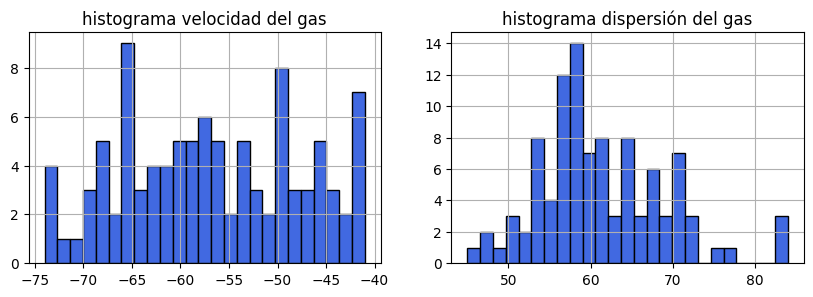

In [ ]:
vel_flat = vel_map_gas.flatten()
vel_clean = vel_flat[np.isfinite(vel_flat)]  # elimina NaNs o inf

sigma_flat = sigma_map_gas.flatten()
sigma_clean = sigma_flat[np.isfinite(sigma_flat)]  # elimina NaNs o inf


fig, ax= plt.subplots(1,2,figsize=(10,3))
ax[0].hist(vel_clean, bins=25, color='royalblue', edgecolor='black')
ax[0].set_title('histograma velocidad del gas')
ax[0].grid('on')
ax[1].hist(sigma_clean, bins=25, color='royalblue', edgecolor='black')
ax[1].set_title('histograma dispersión del gas')
ax[1].grid('on')
plt.show()

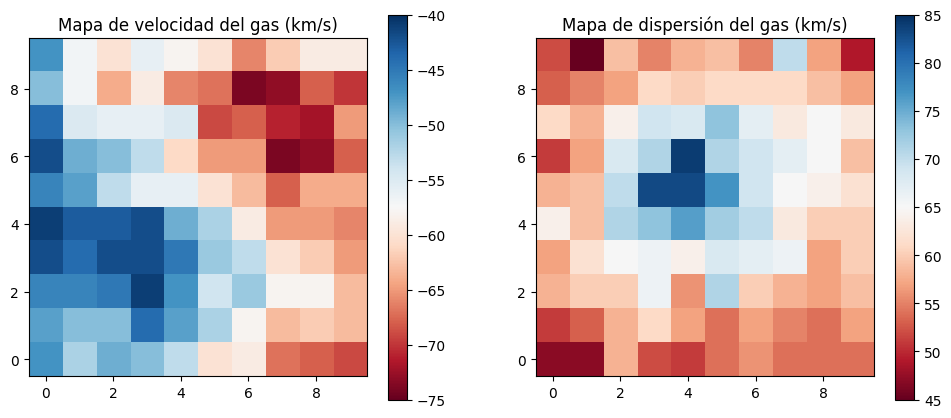

In [ ]:
#ahora graficamos los mapas de velocidad

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
im1 = ax[0].imshow(vel_map_gas, origin='lower', cmap='RdBu', vmin=-75, vmax=-40)
ax[0].set_title("Mapa de velocidad del gas (km/s)")
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].imshow(sigma_map_gas, origin='lower', cmap='RdBu', vmin=45, vmax=85)
ax[1].set_title("Mapa de dispersión del gas (km/s)")
fig.colorbar(im2, ax=ax[1])
plt.show()

* En el mapa de velocidad del gas muestra una gradiente cinematica: en la zona de las velocidades menos negativas ( osea colores más claros y azulados), mientras que hacia la parte superior derecha las velocidades alcanzan valores más negativos (rojizos), lo que nos puede decir que el gas rota alrededor del centro de la galaxia.

* En el mapa de disperción revela que las velocidades de gas son más homogeneas en los bordes mientras que en la región central hay peaks más altos de dispersión. Este aumento en la dispersión interna central puede relacionarse a fenómenos que agitan el medio mientras que en las zonas externas el gas se comporta de forma más fría y menos turbulenta.

# Conclusiones

Se utiliza pPXF en cada pixel del cubo IFU del NGC 4990 para caracterizar tanto las componentes estelar como gaseosa, logrando mapas completos de velocidad, dispersión, edad y metalicidad. En la parte estelar, los valores de velocidad radial son negativos y muestran un claro gradiente de abajo hacia arriba y relativamente al centro (pixel 4,6 aprox...)  se encuentra la velocidad más alta (en módulo). La dispersión de las velocidades estelares se muestra mayor en los bordes de la galaxia pero no es del todo homogénea,  lo cual tal vez es debido detalles con el ajuste (que es preeliminar al proceso completo habitual para modelar por completo las galaxias).

A partir de los pesos de los modelos, los mapas de metalicidad y edad reflejan que el núcleo de NGC alberga una población relativamente más vieja que a los alrededores a excepción de una línea (pixeles x=8 y en y=(2,7)) donde son más viejas. En cuanto a la metalicidad tenemos valores mayores en los bordes y sobre todo en la esquina superior izquierda mientras que en el centro tenemos baja metalicidad (metal poor). lo cual puede deberse a algún mecanismo dentro de la galaxia que expulsa los metales del centro. En el gas ionizado, los mapas de velocidad exhiben un patrón de rotación similar al estelar, aunque con ligeros desplazamientos diferentes, y las dispersiones moleculares son menores en las regiones externas (60 km/s) y alcanzan valores más altos, como (100 km/s), cerca del núcleo, lo que indica una mayor agitación local.

Al incorporar la sección de líneas de emisión en el ajuste regularizado, se determinó que la edad y metalicidad en el gas central son comunes alrededor de 9.2 Gyr y entre [Z/H] >~-0.2 y 0.2, lo que confirma que el medio interestelar tiene una historia en el enriquecimiento estelar. En conjunto, estos hallazgos justifican el uso de pPXF para descomponer la señal espectral y demuestran que NGC 4990 es una galaxia lenticular con un tipo de núcleo viejo pero menos enriquecido, un disco rotacional frío y un gas ionizado que presenta dinámicas similares a las de las estrellas, aunque con mayor turbulencia en la zona central.
